In [2]:
# 드라이브에 접근할 수 있도록 아래 코드 입력
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 무비렌즈 데이터
+ 추천 시스템에 사용될 모델 학습에선 데이터가 필수!
+ 무비렌즈 데이터를 추천 모델 학습에 필요한 형태로 `가공`해봄

## 랭킹(Ranking)

+ 유저에게 적합한 아이템 Top K개를 추천
+ Top K개를 선정하기 위한 기준 혹은 `Score`가 필요하지만, 유저`X`가 아이템 `Y`에 가지는 **정확한 선호도를 구할 필요 X**<br>
_평가 지표 : Precision@K, Recall@K, MAP@K, nDCG@K_


## 데이터 특징
+ 유저가 영화에게 준 평점 데이터가 있음
+ 영화에 대한 제목, 장르, 연도 등이 있음
+ 유저에 대한 성별, 연령, 직업, 주소 등이 있음
+ **Explicit Feedback** : 선호도 1.0 ~ 5.0 사이의 점수로 표현

### 헤더 선언

In [4]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import random
from matplotlib import pyplot as plt
from datetime import datetime
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### 데이터 초기화

In [5]:
path = '/content/drive/MyDrive/Colab_Notebook/learning_spoons_recommendation_system/data/ml-100k/' # '/data/ml-100k'

ratings_df = pd.read_csv(path + 'u.data', sep='\t', encoding='latin-1', header=None)
movies_df = pd.read_csv(path + 'u.item', sep='|', encoding='latin-1', header=None)
users_df = pd.read_csv(path + 'u.user', sep='|', encoding='latin-1', header=None)

ratings_df.columns = ['user_id', 'movie_id', 'rating', 'timestamp']
movies_df.columns =  ['movie_id', 'movie_title', 'release_date', 'video_release_date',
                     'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 
                     'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
                     'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
                     'Thriller', 'War', 'Western']
users_df.columns = ['user_id', 'age', 'gender', 'occupation', 'zip_code']

+ timestamp를 datetime으로 변경!
+ 추천 문제에서 보통 과거 데이터를 `학습`해서 현재, 미래에 추천하기 때문에 `시간`은 **트레이닝 데이터와 테스트 데이터를 나눌 때** 매우 중요

In [6]:
ratings_df['datetime'] = pd.to_datetime(ratings_df['timestamp'], unit='s')
ratings_df['date'] = ratings_df['datetime'].dt.strftime('%Y-%m-%d').astype(str)

### 평점 데이터의 기초 통계량


+ 데이터에 대한 기본적인 통계 정보를 확인
+ 몇가지 정보에 대해서 `Visualization`

In [ ]:
n_user = len(ratings_df['user_id'].unique())    # 유저 수
n_movie = len(ratings_df['movie_id'].unique())    # 영화 수

print('유저 수 :', n_user, '영화 수 :', n_movie)

# 평점 데이터 정보
ratings_df.info()

유저 수 : 943 영화 수 : 1682
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   user_id    100000 non-null  int64         
 1   movie_id   100000 non-null  int64         
 2   rating     100000 non-null  int64         
 3   timestamp  100000 non-null  int64         
 4   datetime   100000 non-null  datetime64[ns]
 5   date       100000 non-null  object        
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 4.6+ MB


In [ ]:
# pandas에서 제공하는 기초 통계량, 열 이름 잘못 적으면 오류!
ratings_df[['user_id', 'movie_id', 'rating']].describe()

,user_id,movie_id,rating
count,100000.00000,100000.000000,100000.000000
mean,462.48475,425.530130,3.529860
std,266.61442,330.798356,1.125674
min,1.00000,1.000000,1.000000
25%,254.00000,175.000000,3.000000
50%,447.00000,322.000000,4.000000
75%,682.00000,631.000000,4.000000
max,943.00000,1682.000000,5.000000


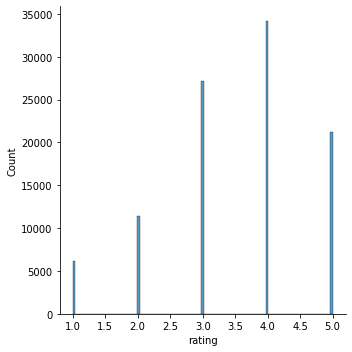

In [ ]:
# 평점 데이터 분포
sns.displot(ratings_df['rating'])

In [ ]:
# 사용자 별로 aggregate한 데이터 확인
user_stastics = pd.DataFrame({
    'numRating' : ratings_df.groupby('user_id')['movie_id'].nunique(),
    'avgRating' : ratings_df.groupby('user_id')['movie_id'].mean(),
    'stdRating' : ratings_df.groupby('user_id')['movie_id'].std(),
}).reset_index()

user_stastics.head()

,user_id,numRating,avgRating,stdRating
0,1,272,136.500000,78.663842
1,2,62,249.500000,93.021194
2,3,54,318.814815,33.955061
3,4,24,291.041667,90.440218
4,5,175,291.291429,140.223880


================사용자의 평점 분포=================
=============사용자의 평가 영화 개수 분포==============


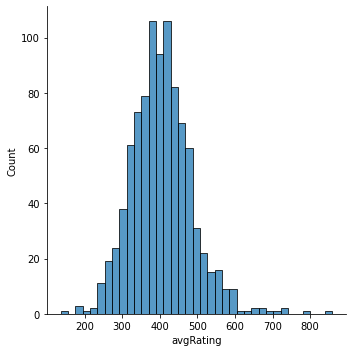

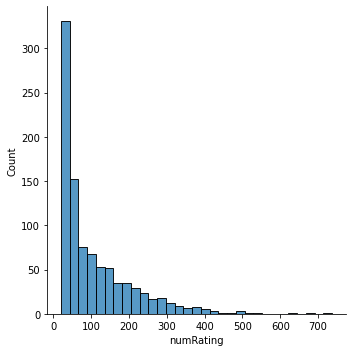

In [ ]:
# 사용자의 평점 분포
# print('{0:=^43}'.format('사용자의 평점 분포'))
sns.displot(user_stastics['avgRating'])

# 사용자 평가 영화 개수 분포
sns.displot(user_stastics['numRating'])

### 인기도 기반 영화 추천(Popular, Highly Rated)

+ Popular : 가장 많은 유저가 본 영화(혹은 평가를 받은)
+ Highly Rated : 가장 높은 평점을 받은 영화

In [7]:
# 영화 Ranking을 위한 영화별 통계량 계산

movie_statistics = pd.DataFrame({
    'numUsers': ratings_df.groupby('movie_id')['user_id'].nunique(),
    'avgRating': ratings_df.groupby('movie_id')['rating'].mean(), 
    'stdRating': ratings_df.groupby('movie_id')['rating'].std()
}).reset_index()

movie_statistics.head()

,movie_id,numUsers,avgRating,stdRating
0,1,452,3.878319,0.927897
1,2,131,3.206107,0.966497
2,3,90,3.033333,1.212760
3,4,209,3.550239,0.965069
4,5,86,3.302326,0.946446


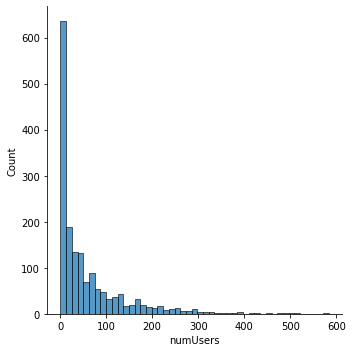

In [ ]:
# 영화별 평가 개수 분포
sns.displot(movie_statistics['numUsers'])

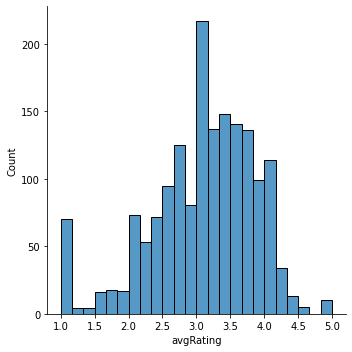

In [ ]:
# 영화별 평균 평점의 분포
sns.displot(movie_statistics['avgRating'])

### Popular


In [ ]:
# 가장 많은 유저가 본 영화 Top 10
top10_df = movie_stastics.sort_values(by='numUsers', ascending=False)[:10]
pd.merge(top10_df, movies_df[['movie_id', 'movie_title', 'release_date']], how='inner', on='movie_id')

,movie_id,numUsers,avgRating,stdRating,movie_title,release_date
0,50,583,4.358491,0.881341,Star Wars (1977),01-Jan-1977
1,258,509,3.803536,0.994427,Contact (1997),11-Jul-1997
2,100,508,4.155512,0.975756,Fargo (1996),14-Feb-1997
3,181,507,4.007890,0.923955,Return of the Jedi (1983),14-Mar-1997
4,294,485,3.156701,1.098544,Liar Liar (1997),21-Mar-1997
5,286,481,3.656965,1.169401,"English Patient, The (1996)",15-Nov-1996
6,288,478,3.441423,1.113910,Scream (1996),20-Dec-1996
7,1,452,3.878319,0.927897,Toy Story (1995),01-Jan-1995
8,300,431,3.631090,0.998072,Air Force One (1997),01-Jan-1997
9,121,429,3.438228,1.116584,Independence Day (ID4) (1996),03-Jul-1996


### Highly Rated

In [8]:
# 평점이 가장 높은 영화 Top 10
top10_df = movie_statistics.sort_values(by='avgRating', ascending=False)[:10]
pd.merge(top10_df, movies_df[['movie_id', 'movie_title', 'release_date']], how='inner', on='movie_id')

,movie_id,numUsers,avgRating,stdRating,movie_title,release_date
0,814,1,5.0,NaN,"Great Day in Harlem, A (1994)",01-Jan-1994
1,1599,1,5.0,NaN,Someone Else's America (1995),10-May-1996
2,1201,1,5.0,NaN,Marlene Dietrich: Shadow and Light (1996),02-Apr-1996
3,1122,1,5.0,NaN,They Made Me a Criminal (1939),01-Jan-1939
4,1653,1,5.0,NaN,Entertaining Angels: The Dorothy Day Story (1996),27-Sep-1996
5,1293,3,5.0,0.0,Star Kid (1997),16-Jan-1998
6,1500,2,5.0,0.0,Santa with Muscles (1996),08-Nov-1996
7,1189,3,5.0,0.0,Prefontaine (1997),24-Jan-1997
8,1536,1,5.0,NaN,Aiqing wansui (1994),22-Jul-1996
9,1467,2,5.0,0.0,"Saint of Fort Washington, The (1993)",01-Jan-1993


### Steam Rating

+ `Steam Rating Fomular`를 활용한 평균 평점

In [9]:
movie_statistics['steamRating'] = movie_statistics['avgRating'] - (movie_statistics['avgRating'] - 3.0) \
                                  * np.power(2, -np.log10(movie_statistics['numUsers']))
top10_df = movie_statistics.sort_values(by = 'steamRating', ascending=False)[:10]
pd.merge(top10_df, movies_df[['movie_id', 'movie_title', 'release_date']], how='inner', on ='movie_id')


,movie_id,numUsers,avgRating,stdRating,steamRating,movie_title,release_date
0,318,298,4.466443,0.829109,4.202535,Schindler's List (1993),01-Jan-1993
1,64,283,4.445230,0.767008,4.181064,"Shawshank Redemption, The (1994)",01-Jan-1994
2,483,243,4.456790,0.728114,4.178012,Casablanca (1942),01-Jan-1942
3,50,583,4.358491,0.881341,4.158731,Star Wars (1977),01-Jan-1977
4,408,112,4.491071,0.771047,4.130806,"Close Shave, A (1995)",28-Apr-1996
5,12,267,4.385768,0.825500,4.127995,"Usual Suspects, The (1995)",14-Aug-1995
6,169,118,4.466102,0.823607,4.117391,"Wrong Trousers, The (1993)",01-Jan-1993
7,603,209,4.387560,0.712551,4.109705,Rear Window (1954),01-Jan-1954
8,98,390,4.289744,0.836597,4.075694,"Silence of the Lambs, The (1991)",01-Jan-1991
9,127,413,4.283293,0.934577,4.073956,"Godfather, The (1972)",01-Jan-1972


### 휴리스틱 랭킹 스코어

+ `Popular`와 `Highly Rated`를 모두 고려
+ 각 Ranking 스코어를 조합하여 휴리스틱한 스코어를 만듦
+ 보통 `Popular` 스코어는 크게 증가하기 때문에 `log`를 사용하고, rating 스코어는 `지수`를 사용해서 조정

> 휴리스틱(Heuristics)
>> 어림짐작하기<br>
>> 직관적으로 판단하기

In [10]:
# 평점과 본 유저수를 모두 고려한 스코어
# score = log(numUsers) * (avgRating) ^ alpha

alpha = 0.8

movie_statistics['score'] = np.log(movie_statistics['numUsers']) * np.power( movie_statistics['numUsers'], alpha)
top10_df = movie_statistics.sort_values(by='score', ascending=False)[:10]
pd.merge(top10_df, movies_df[['movie_id', 'movie_title', 'release_date']], how='inner', on='movie_id')

,movie_id,numUsers,avgRating,stdRating,steamRating,score,movie_title,release_date
0,50,583,4.358491,0.881341,4.158731,1038.844786,Star Wars (1977),01-Jan-1977
1,258,509,3.803536,0.994427,3.680452,912.079912,Contact (1997),11-Jul-1997
2,100,508,4.155512,0.975756,3.978408,910.358763,Fargo (1996),14-Feb-1997
3,181,507,4.007890,0.923955,3.853320,908.637389,Return of the Jedi (1983),14-Mar-1997
4,294,485,3.156701,1.098544,3.132346,870.709591,Liar Liar (1997),21-Mar-1997
5,286,481,3.656965,1.169401,3.554603,863.801621,"English Patient, The (1996)",15-Nov-1996
6,288,478,3.441423,1.113910,3.372515,858.618182,Scream (1996),20-Dec-1996
7,1,452,3.878319,0.927897,3.738882,813.604995,Toy Story (1995),01-Jan-1995
8,300,431,3.631090,0.998072,3.529457,777.126933,Air Force One (1997),01-Jan-1997
9,121,429,3.438228,1.116584,3.367556,773.647019,Independence Day (ID4) (1996),03-Jul-1996


## 장르별 추천

+ 전체 영화에 대한 랭킹을 구할 수도 있지만, 장르별로 평점의 분포와 경향성이 다르기 때문에 장르 내에서 랭킹을 수행하기도 합니다.

In [11]:
genre_list = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy',
              'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
              'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

In [12]:
# 장르별 평균 평점
rating_df_with_genre = pd.merge(ratings_df, movies_df, how='inner', on='movie_id')

result = []

for genre in genre_list:
    numUser = rating_df_with_genre[rating_df_with_genre[genre] == 1]['rating'].count()
    avg = rating_df_with_genre[rating_df_with_genre[genre] == 1]['rating'].mean()
    std = rating_df_with_genre[rating_df_with_genre[genre] == 1]['rating'].std()
    result.append([numUser, avg, std])

genre_statistics = pd.DataFrame(result, index=genre_list, columns=['numUsers', 'avgRating', 'stdRating'])
genre_statistics.sort_values(by='avgRating', ascending=False)

,numUsers,avgRating,stdRating
Film-Noir,1733,3.921523,0.993433
War,9398,3.815812,1.080271
Drama,39895,3.687379,1.079125
Documentary,758,3.672823,1.180455
Mystery,5245,3.638132,1.091117
Crime,8055,3.632278,1.112540
Romance,19461,3.621705,1.096125
Western,1854,3.613269,1.041946
Animation,3605,3.576699,1.096615
Sci-Fi,12730,3.560723,1.133190


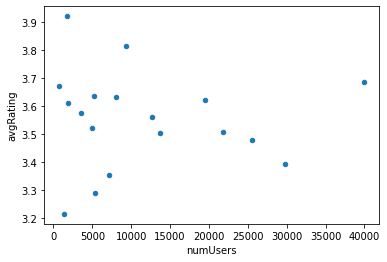

In [ ]:
# 장르별 평균 평점 산포도
genre_statistics.plot.scatter(x='numUsers', y='avgRating')

In [13]:
# Genre 별 steamRating을 이용해 Top 10 구하기
genre = 'Action'

movie_statistics_with_genre = pd.merge(movie_statistics, movies_df, how='inner', on='movie_id')
top10_df_genre = movie_statistics_with_genre[movie_statistics_with_genre[genre] == 1]\
                    .sort_values(by='steamRating', ascending=False)[:10]
top10_df_genre

,movie_id,numUsers,avgRating,stdRating,steamRating,score,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
49,50,583,4.358491,0.881341,4.158731,1038.844786,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0
126,127,413,4.283293,0.934577,4.073956,745.770461,"Godfather, The (1972)",01-Jan-1972,NaN,"http://us.imdb.com/M/title-exact?Godfather,%20...",0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
173,174,420,4.252381,0.891819,4.049117,757.974657,Raiders of the Lost Ark (1981),01-Jan-1981,NaN,http://us.imdb.com/M/title-exact?Raiders%20of%...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
312,313,350,4.245714,0.946822,4.032126,635.329245,Titanic (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?imdb-title-12...,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
171,172,367,4.204360,0.922803,4.000789,665.241548,"Empire Strikes Back, The (1980)",01-Jan-1980,NaN,http://us.imdb.com/M/title-exact?Empire%20Stri...,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,1,0
172,173,324,4.172840,0.998948,3.967019,589.412998,"Princess Bride, The (1987)",01-Jan-1987,NaN,http://us.imdb.com/M/title-exact?Princess%20Br...,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
514,515,201,4.203980,0.901767,3.960037,369.065495,"Boot, Das (1981)",04-Apr-1997,NaN,"http://us.imdb.com/M/title-exact?Boot,%20Das%2...",0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
186,187,209,4.186603,0.919141,3.948989,383.573050,"Godfather: Part II, The (1974)",01-Jan-1974,NaN,http://us.imdb.com/M/title-exact?Godfather:%20...,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
21,22,297,4.151515,0.962440,3.944074,541.504651,Braveheart (1995),16-Feb-1996,NaN,http://us.imdb.com/M/title-exact?Braveheart%20...,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
497,498,152,4.184211,0.758362,3.923218,279.585197,"African Queen, The (1951)",01-Jan-1951,NaN,http://us.imdb.com/M/title-exact?African%20Que...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0


### 사용자 데모그래픽을 활용한 추천

In [14]:
demo_ratings_df = pd.merge(ratings_df, users_df, how='inner', on='user_id')

def age_map(x):
    if x < 20:
        return 10
    elif 20 <= x and x < 30:
        return 20
    elif 30 <= x and x < 40:
        return 30
    elif 40 <= x and x < 50:
        return 40
    else:
        return 50

demo_ratings_df['age'] = demo_ratings_df['age'].apply(lambda x: age_map(x))

# 영화 ranking을 위한 영화별 통계량 계산

demo_movie_statistics = pd.DataFrame({
    'numUsers': demo_ratings_df.groupby(['gender', 'age', 'movie_id'])['user_id'].nunique(),
    'avgRating': demo_ratings_df.groupby(['gender', 'age', 'movie_id'])['rating'].mean(), 
    'stdRating': demo_ratings_df.groupby(['gender', 'age', 'movie_id'])['rating'].std()
}).reset_index()

demo_movie_statistics.head()

,gender,age,movie_id,numUsers,avgRating,stdRating
0,F,10,1,13,3.769231,1.091928
1,F,10,2,2,3.000000,1.414214
2,F,10,3,1,5.000000,NaN
3,F,10,4,2,2.500000,0.707107
4,F,10,5,2,4.500000,0.707107


In [15]:
# Steam Rating
demo_movie_statistics['steamRating'] = demo_movie_statistics['avgRating'] \
                                        - (demo_movie_statistics['avgRating'] - 3.0) * np.power(2, -np.log10(demo_movie_statistics['numUsers']))


In [16]:
# 30대 남자
gender = 'M'
age = 30

filter_df = demo_movie_statistics[(demo_movie_statistics['gender'] == gender) & (demo_movie_statistics['age'] == age)]
top10_df = filter_df.sort_values(by='steamRating')[:10]
pd.merge(top10_df, movies_df[['movie_id', 'movie_title', 'release_date']], how='inner', on='movie_id')

,gender,age,movie_id,numUsers,avgRating,stdRating,steamRating,movie_title,release_date
0,M,30,1215,10,1.600000,0.699206,2.300000,Barb Wire (1996),03-May-1996
1,M,30,688,8,1.500000,1.069045,2.302110,Leave It to Beaver (1997),22-Aug-1997
2,M,30,457,5,1.200000,0.447214,2.308821,Free Willy 3: The Rescue (1997),08-Aug-1997
3,M,30,383,5,1.200000,0.447214,2.308821,"Flintstones, The (1994)",01-Jan-1994
4,M,30,948,10,1.700000,0.948683,2.350000,Booty Call (1997),28-Feb-1997
5,M,30,325,23,1.956522,1.065076,2.362556,Crash (1996),21-Mar-1997
6,M,30,368,5,1.400000,0.894427,2.385619,Bio-Dome (1996),01-Jan-1996
7,M,30,1013,5,1.400000,0.547723,2.385619,Anaconda (1997),11-Apr-1997
8,M,30,120,15,1.933333,0.883715,2.405385,Striptease (1996),28-Jun-1996
9,M,30,1234,3,1.000000,0.000000,2.436819,Chairman of the Board (1998),01-Jan-1998


In [17]:
# 40대 여자
gender = 'F'
age = 20

filter_df = demo_movie_statistics[(demo_movie_statistics['gender'] == gender) & (demo_movie_statistics['age'] == age)]
top10_df = filter_df.sort_values(by='steamRating')[:10]
pd.merge(top10_df, movies_df[['movie_id', 'movie_title', 'release_date']], how='inner', on='movie_id')

,gender,age,movie_id,numUsers,avgRating,stdRating,steamRating,movie_title,release_date
0,F,20,569,5,1.400000,0.894427,2.385619,Wolf (1994),01-Jan-1994
1,F,20,669,4,1.250000,0.500000,2.402922,Body Parts (1991),01-Jan-1991
2,F,20,590,3,1.000000,0.000000,2.436819,Hellraiser: Bloodline (1996),08-Mar-1996
3,F,20,545,3,1.000000,0.000000,2.436819,Vampire in Brooklyn (1995),01-Jan-1995
4,F,20,1079,5,1.600000,1.341641,2.462417,Joe's Apartment (1996),26-Jul-1996
5,F,20,997,4,1.500000,1.000000,2.488219,Stuart Saves His Family (1995),01-Jan-1995
6,F,20,1229,4,1.500000,0.577350,2.488219,Poison Ivy II (1995),01-Jan-1995
7,F,20,743,4,1.500000,0.577350,2.488219,"Crow: City of Angels, The (1996)",30-Aug-1996
8,F,20,554,7,1.857143,0.899735,2.493341,Waterworld (1995),01-Jan-1995
9,F,20,240,12,2.083333,0.996205,2.517189,Beavis and Butt-head Do America (1996),20-Dec-1996


In [18]:
for gender in ['M', 'F']:
    for age in [10, 20, 30, 40, 50, 60]:
        filter_df = demo_movie_statistics[(demo_movie_statistics['gender'] == gender) & (demo_movie_statistics['age'] == age)]
        top10_df = filter_df.sort_values(by = 'steamRating', ascending=False)[:10]
        print(gender, age)
        print(pd.merge(top10_df, movies_df[['movie_id', 'movie_title', 'release_date']], how='inner', on ='movie_id')['movie_title'].values)

M 10
['Star Wars (1977)' 'Empire Strikes Back, The (1980)'
 'Return of the Jedi (1983)' 'Shawshank Redemption, The (1994)'
 'Good Will Hunting (1997)' 'Usual Suspects, The (1995)' 'Clerks (1994)'
 'Godfather, The (1972)' 'Godfather: Part II, The (1974)'
 'Casablanca (1942)']
M 20
['Shawshank Redemption, The (1994)' 'Star Wars (1977)'
 'Godfather, The (1972)' 'Silence of the Lambs, The (1991)'
 'Usual Suspects, The (1995)' 'Empire Strikes Back, The (1980)'
 'Princess Bride, The (1987)' 'Raiders of the Lost Ark (1981)'
 'Titanic (1997)' 'Casablanca (1942)']
M 30
['Casablanca (1942)' 'Star Wars (1977)'
 "One Flew Over the Cuckoo's Nest (1975)" 'Rear Window (1954)'
 'North by Northwest (1959)' 'Godfather, The (1972)'
 'Raiders of the Lost Ark (1981)' "Schindler's List (1993)"
 'Usual Suspects, The (1995)' 'Raging Bull (1980)']
M 40
['Casablanca (1942)' "Schindler's List (1993)" 'Wizard of Oz, The (1939)'
 'Usual Suspects, The (1995)' 'Shawshank Redemption, The (1994)'
 'Ran (1985)' 'Vertig

# Association Rule 구현
- 10개의 `transaction`으로 이루어진 데이터를 활용하여 `association rule`을 간단하게 구현
- `support`, `confidence`, `lift` 값을 직접 구해보기

In [19]:
pip install mlxtend --upgrade --no-deps

     |████████████████████████████████| 1.4MB 29.6MB/s 
  Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


In [20]:
import csv
import pandas as pd
import random
from datetime import datetime
from collections import defaultdict
import seaborn as sns
import numpy as np

from mlxtend.frequent_patterns import apriori, fpgrowth
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder

from matplotlib import pyplot as plt
%matplotlib inline

In [75]:
!head -n 5 '/content/drive/MyDrive/Colab_Notebook/learning_spoons_recommendation_system/data/transaction.csv'

Bread,Milk
Bread,Diapers,Beer,Eggs
Milk,Diapers,Beer,Cola
Bread,Milk,Diapers,Beer
Bread,Milk,Diapers,Cola


In [76]:
file_path = '/content/drive/MyDrive/Colab_Notebook/learning_spoons_recommendation_system/data/transaction.csv'
trans_list_set = []

with open(file_path, 'r') as file:
    reader = csv.reader(file, delimiter=',')
    for line in reader:
        trans_list_set.append(set(line))

trans_length = len(trans_list_set)  # 10
trans_list_set

[{'Bread', 'Milk'},
 {'Beer', 'Bread', 'Diapers', 'Eggs'},
 {'Beer', 'Cola', 'Diapers', 'Milk'},
 {'Beer', 'Bread', 'Diapers', 'Milk'},
 {'Bread', 'Cola', 'Diapers', 'Milk'},
 {'Bread', 'Milk'},
 {'Beer', 'Bread', 'Cola', 'Milk'},
 {'Beer', 'Bread', 'Cola', 'Milk'},
 {'Beer', 'Bread', 'Diapers', 'Milk'},
 {'Beer', 'Bread', 'Diapers'}]

- `frozenset`을 사용하는 이유
    - 우리가 필요한 `itemset`은 python에서 제공하는 `set`과 동일
    - `frozenset`은 불변 객체이므로 새로운 아이템의 추가나 삭제가 불가 $\to$ 사용하는 이유!, `pandas`에도 `value` 값으로 사용할 수 있다

In [77]:
# 1-itemset 생성

item_set = set()
for line in trans_list_set:
    for item in line:
        item_set.add(frozenset([item]))
item_set

{frozenset({'Diapers'}),
 frozenset({'Cola'}),
 frozenset({'Bread'}),
 frozenset({'Eggs'}),
 frozenset({'Beer'}),
 frozenset({'Milk'})}

## support 계산, frequent itemset 구하기

In [25]:
# frequent itemset의 support를 저장하는 dictionary
# frequent itemset : 최소한의 support 이상의 k-itemset을 의미

min_support = 0.2
support_dict = defaultdict(float)

In [78]:
# 1-itemset의 frequent itemset 계산
one_freq_set = set()
one_freq_dict = defaultdict(int)

# 1-itemset의 support count 계산
for item in item_set:
    one_freq_dict[item] += sum([1 for trans in trans_list_set if item.issubset(trans)])

# min support 이상의 itemset만 보존

n = len(trans_list_set)
for item, cnt in one_freq_dict.items():
    support = float(cnt) / n
    if support >= min_support:
        one_freq_set.add(item)
        support_dict[item] = support

print('{0:=^60}'.format('1-itemset'))
support_dict


=========================1-itemset==========================


defaultdict(float,
            {frozenset({'Diapers'}): 0.6,
             frozenset({'Cola'}): 0.4,
             frozenset({'Bread'}): 0.9,
             frozenset({'Beer'}): 0.7,
             frozenset({'Milk'}): 0.8,
             frozenset({'Beer', 'Bread'}): 0.6,
             frozenset({'Diapers', 'Milk'}): 0.4,
             frozenset({'Beer', 'Cola'}): 0.3,
             frozenset({'Beer', 'Diapers'}): 0.5,
             frozenset({'Cola', 'Diapers'}): 0.2,
             frozenset({'Bread', 'Cola'}): 0.3,
             frozenset({'Bread', 'Diapers'}): 0.5,
             frozenset({'Beer', 'Milk'}): 0.5,
             frozenset({'Cola', 'Milk'}): 0.4,
             frozenset({'Bread', 'Milk'}): 0.7})

In [79]:

# 2-frequency itemset

k = 2
two_item_set = set([term1.union(term2) for term1 in one_freq_set
                        for term2 in one_freq_set if len(term1.union(term2)) == k])

two_freq_set = set()
two_freq_dict = defaultdict(int)

# 2-itemset의 support count 계산
for item in two_item_set:
    two_freq_dict[item] += sum(1 for trans in trans_list_set if item.issubset(trans))

n = len(trans_list_set)
for item, cnt in two_freq_dict.items():
    support = float(cnt) / n
    if support >= min_support:
        one_freq_set.add(item)
        support_dict[item] = support

print('{0:=^60}'.format('2-frequency itemset'))
support_dict

====================2-frequency itemset=====================


defaultdict(float,
            {frozenset({'Diapers'}): 0.6,
             frozenset({'Cola'}): 0.4,
             frozenset({'Bread'}): 0.9,
             frozenset({'Beer'}): 0.7,
             frozenset({'Milk'}): 0.8,
             frozenset({'Beer', 'Bread'}): 0.6,
             frozenset({'Diapers', 'Milk'}): 0.4,
             frozenset({'Beer', 'Cola'}): 0.3,
             frozenset({'Beer', 'Diapers'}): 0.5,
             frozenset({'Cola', 'Diapers'}): 0.2,
             frozenset({'Bread', 'Cola'}): 0.3,
             frozenset({'Bread', 'Diapers'}): 0.5,
             frozenset({'Beer', 'Milk'}): 0.5,
             frozenset({'Cola', 'Milk'}): 0.4,
             frozenset({'Bread', 'Milk'}): 0.7})

In [80]:
# 3-frequency itemset을 생성하는 과정

k = 3

# 2-itemset을 사용해서 후보 3-itemset들을 생성합니다
three_item_set = set([term1.union(term2) for term1 in two_freq_set for term2 in two_freq_set if len(term1.union(term2)) == k])

three_freq_set  = set()
three_freq_dict = defaultdict(int)

# 2-itemset의 support count 계산
for item in three_item_set:
    three_freq_dict[item] += sum([1 for trans in trans_list_set if item.issubset(trans)])

# 2-itemset 가운데 min support 이상의 itemset만 보존시킨다.
n = len(trans_list_set)
for item, cnt in three_freq_dict.items():
    support = float(cnt) / n
    if support >= min_support:
        three_freq_set.add(item)
        support_dict[item] = support

support_dict

defaultdict(float,
            {frozenset({'Diapers'}): 0.6,
             frozenset({'Cola'}): 0.4,
             frozenset({'Bread'}): 0.9,
             frozenset({'Beer'}): 0.7,
             frozenset({'Milk'}): 0.8,
             frozenset({'Beer', 'Bread'}): 0.6,
             frozenset({'Diapers', 'Milk'}): 0.4,
             frozenset({'Beer', 'Cola'}): 0.3,
             frozenset({'Beer', 'Diapers'}): 0.5,
             frozenset({'Cola', 'Diapers'}): 0.2,
             frozenset({'Bread', 'Cola'}): 0.3,
             frozenset({'Bread', 'Diapers'}): 0.5,
             frozenset({'Beer', 'Milk'}): 0.5,
             frozenset({'Cola', 'Milk'}): 0.4,
             frozenset({'Bread', 'Milk'}): 0.7})

## confidence, lift 구하기

X $\to$ Y, X : `antecedent` Y : `consequent`

In [61]:
x = 'Diapers'
y = 'Beer'

x_support = support_dict.get(frozenset([x]), 0.0)
y_support = support_dict.get(frozenset([y]), 0.0)
both_support = support_dict.get(frozenset([x, y]), 0.0)

confidence = both_support / x_support
print('Confidence : ', confidence)

lift = both_support / (x_support * y_support)
print('Lift : ', lift)

Confidence :  0.8333333333333334
Lift :  1.1904761904761905


## association rule 구하기

X에 대해 가능한 모든 `association rule`을 구하기

In [81]:
x = 'Diapers'
x = frozenset([x])
x_support = support_dict.get(x, 0.0)

for y, y_support in support_dict.items():
    if y != x:
        y_support = support_dict.get(y, 0.0)
        both_support = support_dict.get(x.union(y), 0.0)

        confidence = both_support / x_support
        lift = both_support / (x_support * y_support)

        print('%s -> %s support : %0.3f, confidence : %0.3f, lift : %0.3f' \
              % (list(x), list(y), both_support, confidence, lift))

['Diapers'] -> ['Cola'] support : 0.200, confidence : 0.333, lift : 0.833
['Diapers'] -> ['Bread'] support : 0.500, confidence : 0.833, lift : 0.926
['Diapers'] -> ['Beer'] support : 0.500, confidence : 0.833, lift : 1.190
['Diapers'] -> ['Milk'] support : 0.400, confidence : 0.667, lift : 0.833
['Diapers'] -> ['Bread', 'Beer'] support : 0.000, confidence : 0.000, lift : 0.000
['Diapers'] -> ['Diapers', 'Milk'] support : 0.400, confidence : 0.667, lift : 1.667
['Diapers'] -> ['Beer', 'Cola'] support : 0.000, confidence : 0.000, lift : 0.000
['Diapers'] -> ['Diapers', 'Beer'] support : 0.500, confidence : 0.833, lift : 1.667
['Diapers'] -> ['Diapers', 'Cola'] support : 0.200, confidence : 0.333, lift : 1.667
['Diapers'] -> ['Bread', 'Cola'] support : 0.000, confidence : 0.000, lift : 0.000
['Diapers'] -> ['Diapers', 'Bread'] support : 0.500, confidence : 0.833, lift : 1.667
['Diapers'] -> ['Milk', 'Beer'] support : 0.000, confidence : 0.000, lift : 0.000
['Diapers'] -> ['Milk', 'Cola'] 

모든 서로소`disjoint`에 대하여 가능한 `association rule`을 구하는 로직입니다.

In [65]:
result_df = pd.DataFrame(columns= ['antecedent', 'consequent', 'support', 'confidence', 'lift'])

for x, x_support in support_dict.items():
    for y, y_support in support_dict.items():
        if x.isdisjoint(y):
            both_support = support_dict.get(x.union(y), 0.0)

            confidence = both_support / x_support
            lift = both_support / (x_support * y_support)
            result_df.loc[len(result_df)] = [x, y, both_support, confidence, lift]

result_df

,antecedent,consequent,support,confidence,lift
0,(Diapers),(Cola),0.2,0.333333,0.833333
1,(Diapers),(Bread),0.5,0.833333,0.925926
2,(Diapers),(Beer),0.5,0.833333,1.190476
3,(Diapers),(Milk),0.4,0.666667,0.833333
4,(Diapers),"(Bread, Beer)",0.0,0.000000,0.000000
...,...,...,...,...,...
105,"(Milk, Bread)",(Cola),0.0,0.000000,0.000000
106,"(Milk, Bread)",(Beer),0.0,0.000000,0.000000
107,"(Milk, Bread)","(Beer, Cola)",0.0,0.000000,0.000000
108,"(Milk, Bread)","(Diapers, Beer)",0.0,0.000000,0.000000


## association rule을 사용한 추천

In [70]:
support_dict

defaultdict(float,
            {frozenset({'Diapers'}): 0.6,
             frozenset({'Cola'}): 0.4,
             frozenset({'Bread'}): 0.9,
             frozenset({'Beer'}): 0.7,
             frozenset({'Milk'}): 0.8,
             frozenset({'Beer', 'Bread'}): 0.6,
             frozenset({'Diapers', 'Milk'}): 0.4,
             frozenset({'Beer', 'Cola'}): 0.3,
             frozenset({'Beer', 'Diapers'}): 0.5,
             frozenset({'Cola', 'Diapers'}): 0.2,
             frozenset({'Bread', 'Cola'}): 0.3,
             frozenset({'Bread', 'Diapers'}): 0.5,
             frozenset({'Beer', 'Milk'}): 0.5,
             frozenset({'Cola', 'Milk'}): 0.4,
             frozenset({'Bread', 'Milk'}): 0.7})

- Diapers는 `frequent itemset`에 속하므로 `association rule`을 통한 추천이 가능합니다.
- Diapers를 구매했다고 가정할 때 추천 `itemset`을 구해봅니다.

In [68]:
x = 'Diapers'
x_itemset = frozenset([x])
result_df[result_df['antecedent'] == x_itemset].sort_values(by='lift', ascending=False)

,antecedent,consequent,support,confidence,lift
2,(Diapers),(Beer),0.5,0.833333,1.190476
1,(Diapers),(Bread),0.5,0.833333,0.925926
0,(Diapers),(Cola),0.2,0.333333,0.833333
3,(Diapers),(Milk),0.4,0.666667,0.833333
4,(Diapers),"(Bread, Beer)",0.0,0.000000,0.000000
5,(Diapers),"(Beer, Cola)",0.0,0.000000,0.000000
6,(Diapers),"(Bread, Cola)",0.0,0.000000,0.000000
7,(Diapers),"(Milk, Beer)",0.0,0.000000,0.000000
8,(Diapers),"(Milk, Cola)",0.0,0.000000,0.000000
9,(Diapers),"(Milk, Bread)",0.0,0.000000,0.000000


최소 confidence 조건을 추가하려면 아래와 같이 합니다.

In [82]:
x = 'Diapers'
x_itemset = frozenset([x])
min_confidence = 0.3

result_df[(result_df['antecedent'] == x_itemset) \
            & result_df['confidence'] > min_confidence].sort_values(by='lift', ascending=False)

,antecedent,consequent,support,confidence,lift
2,(Diapers),(Beer),0.5,0.833333,1.190476
1,(Diapers),(Bread),0.5,0.833333,0.925926
0,(Diapers),(Cola),0.2,0.333333,0.833333
3,(Diapers),(Milk),0.4,0.666667,0.833333


## mlxtend 라이브러리 사용

- `frequent itemset`을 생성하는 `Aporiori` 알고리즘과 `Association Rule`을 제공하는 라이브러리
- `Apriori` 알고리즘 외에도 더 빠른 `FPGrowth` 등의 알고리즘도 제공

In [85]:
file_path = '/content/drive/MyDrive/Colab_Notebook/learning_spoons_recommendation_system/data/transaction.csv'
transaction_df = pd.DataFrame(columns=['transaction', 'item'])

index = 0
with open(file_path, 'r') as file:
    reader = csv.reader(file, delimiter=',')
    for line in reader:
        for item in line:
            transaction_df.loc[len(transaction_df)] = [index, item]
        index += 1

transaction_df

,transaction,item
0,0,Bread
1,0,Milk
2,1,Bread
3,1,Diapers
4,1,Beer
5,1,Eggs
6,2,Milk
7,2,Diapers
8,2,Beer
9,2,Cola


그중 Top N 아이템을 구합니다

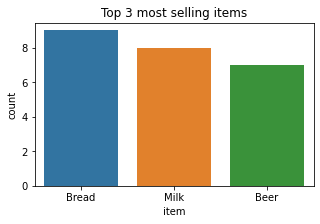

In [86]:
plt.figure(figsize=(5,3))
order = transaction_df['item'].value_counts()[:3].index
sns.countplot(x='item', data=transaction_df, order=order)
plt.title('Top 3 most selling items')
plt.show()

다음은 `mlxtend` 라이브러리 학습을 위한 데이터 포맷을 변경합니다.

In [88]:
from mlxtend.preprocessing import TransactionEncoder

dataset = []

# 2개 이상의 item으로 이뤄진 itemset만 사용
for transaction, df in transaction_df.groupby('transaction'):
    item_list = list(df['item'].unique())
    if len(item_list) > 1:
        dataset.append(item_list)
dataset

[['Bread', 'Milk'],
 ['Bread', 'Diapers', 'Beer', 'Eggs'],
 ['Milk', 'Diapers', 'Beer', 'Cola'],
 ['Bread', 'Milk', 'Diapers', 'Beer'],
 ['Bread', 'Milk', 'Diapers', 'Cola'],
 ['Bread', 'Milk'],
 ['Bread', 'Cola', 'Beer', 'Milk'],
 ['Milk', 'Bread', 'Beer', 'Cola'],
 ['Bread', 'Milk', 'Diapers', 'Beer'],
 ['Bread', 'Beer', 'Diapers']]

In [91]:
te = TransactionEncoder()
te_ary = te.fit(dataset).transform(dataset)
df = pd.DataFrame(te_ary, columns=te.columns_)
df

,Beer,Bread,Cola,Diapers,Eggs,Milk
0,False,True,False,False,False,True
1,True,True,False,True,True,False
2,True,False,True,True,False,True
3,True,True,False,True,False,True
4,False,True,True,True,False,True
5,False,True,False,False,False,True
6,True,True,True,False,False,True
7,True,True,True,False,False,True
8,True,True,False,True,False,True
9,True,True,False,True,False,False


In [93]:
# frequent itemset 생성

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

frequent_itemsets = apriori(df, min_support=0.2, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.7,(Beer)
1,0.9,(Bread)
2,0.4,(Cola)
3,0.6,(Diapers)
4,0.8,(Milk)
5,0.6,"(Bread, Beer)"
6,0.3,"(Beer, Cola)"
7,0.5,"(Diapers, Beer)"
8,0.5,"(Milk, Beer)"
9,0.3,"(Bread, Cola)"


최소 `Confidence` 이상의 `association rule` 생성 및 추천

In [96]:
result = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.3)
result[(result['antecedents'] == frozenset(['Beer']))].sort_values(by='lift', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
5,(Beer),(Diapers),0.7,0.6,0.5,0.714286,1.190476,0.08,1.400000
29,(Beer),"(Diapers, Bread)",0.7,0.5,0.4,0.571429,1.142857,0.05,1.166667
2,(Beer),(Cola),0.7,0.4,0.3,0.428571,1.071429,0.02,1.050000
40,(Beer),"(Milk, Cola)",0.7,0.4,0.3,0.428571,1.071429,0.02,1.050000
47,(Beer),"(Diapers, Milk)",0.7,0.4,0.3,0.428571,1.071429,0.02,1.050000
1,(Beer),(Bread),0.7,0.9,0.6,0.857143,0.952381,-0.03,0.700000
7,(Beer),(Milk),0.7,0.8,0.5,0.714286,0.892857,-0.06,0.700000
35,(Beer),"(Milk, Bread)",0.7,0.7,0.4,0.571429,0.816327,-0.09,0.700000


- 최소 `lift` 이상의 `association rule` 생성 및 추천
- 일반적으로 위와 같이 최소 `confidence`로 `rule`을 cutoff하고 `lift`로 정렬해서 사용합니다.


In [98]:
result = association_rules(frequent_itemsets, metric='lift', min_threshold=1.1)
result[(result['antecedents'] == frozenset(['Beer']))].sort_values(by='lift', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1,(Beer),(Diapers),0.7,0.6,0.5,0.714286,1.190476,0.08,1.400000
7,(Beer),"(Diapers, Bread)",0.7,0.5,0.4,0.571429,1.142857,0.05,1.166667


# Online Retail 데이터를 활용한 Association Rule 생성
- 실제 데이터를 사용해서 간단한 연관 규칙 기반 상품 추천 시스템 제작